## Example deTiN run using data from invitro mixing validation experiment

Loading data and deTiN modules:

In [27]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import deTiN
import deTiN_utilities as du
import deTiN_SSNV_based_estimate as dssnv
import deTiN_aSCNA_based_estimate as dascna
import optparse
args = optparse.Values()
args.mutation_data_path ='example_data/HCC_10_90.call_stats.pon_removed.txt'
args.cn_data_path = 'example_data/HCC-1143_100_T-sim-final.acs.seg'
args.normal_het_data_path ='example_data/HCC_10_90.normal.hets.tsv'
args.tumor_het_data_path = 'example_data/HCC_10_90.tumor.hets.tsv'
args.exac_data_path = 'example_data/exac.pickle_high_af'
args.indel_data_path = 'example_data/MuTect2.call_stats.txt'
args.indel_data_type = 'MuTect2'
args.output_dir = 'example_data/'
args.aSCNA_threshold = 0.1
args.output_name = 'HCC_10_90'
args.use_outlier_removal = True
args.mutation_prior = 0.2
args.TiN_prior = 1
args.resolution = 201
args.weighted_classification = False
di = deTiN.input(args)
di.read_and_preprocess_data()

Estimate tumor in normal based on SSNVs : 

In [28]:
# identify SSNV candidates based on MuTect and panel of normal flags 
di.candidates = du.select_candidate_mutations(di.call_stats_table,di.exac_db_file)
# generate SSNV based model using candidate sites
ssnv_based_model = dssnv.model(di.candidates, di.mutation_prior,di.resolution)
ssnv_based_model.perform_inference()

pre-processing SSNV data
initialized TiN to 0
TiN inference after 1 iterations = 0.09
TiN inference after 2 iterations = 0.11
TiN inference after 3 iterations = 0.115
TiN inference after 4 iterations = 0.115
SSNV based TiN estimate converged: TiN = 0.115


Estimate tumor in normal based on aSCNAs

In [29]:
reload(dascna)
# filter input SNPs based to maintain symmetry 
di.aSCNA_hets = du.ensure_balanced_hets(di.seg_table,di.het_table)
# recalculate minor allele fraction and detect allelic imbalance
di.aSCNA_segs = du.identify_aSCNAs(di.seg_table,di.aSCNA_hets,di.aSCNA_thresh)

identified convergent aSCNA in normal on chromosomes:[2]


In [30]:
reload(dascna)
# generate aSCNA based model 
ascna_based_model = dascna.model(di.aSCNA_segs, di.aSCNA_hets,di.resolution)
# MAP estimate of TiN for each segment and then K-means clustering procedure
ascna_based_model.perform_inference()

calculating aSCNA based TiN estimate using data from chromosomes: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 21]
detected 2 clusters
aSCNA based TiN estimate from selected TiN cluster :  0.125


In [31]:
# calculate joint estimate and recover mutations 
do = deTiN.output(di,ssnv_based_model,ascna_based_model)
do.calculate_joint_estimate()
# reclassify somatic events based on TiN estimate
do.reclassify_mutations()
# write out SSNVs with deTiN annotations (rescued SSNVs are marked KEEP)
do.SSNVs.to_csv(path_or_buf=do.input.output_path + '/' + do.input.output_name + '_deTiN_SSNVs.txt',sep='\t')

joint TiN estimate = 0.125
reclassifying indels


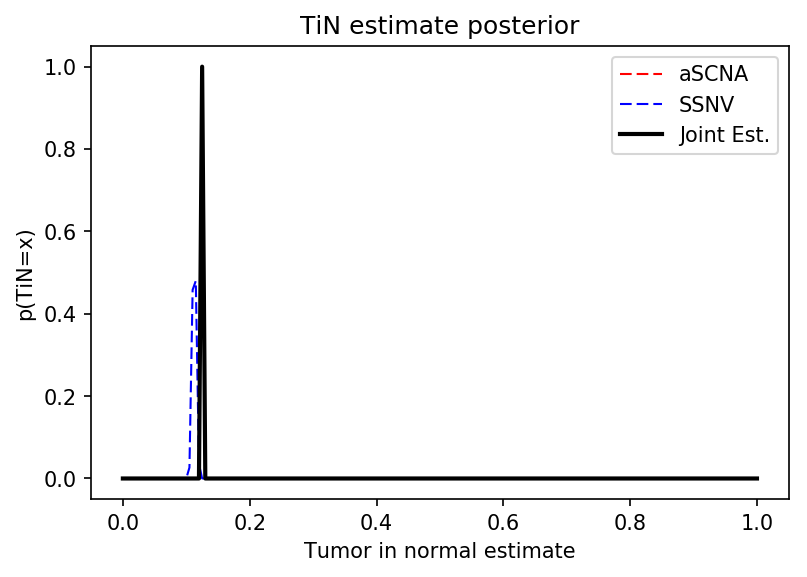

In [32]:
# plot TiN posteriors from each model and the joint estimate
du.plot_TiN_models(do)

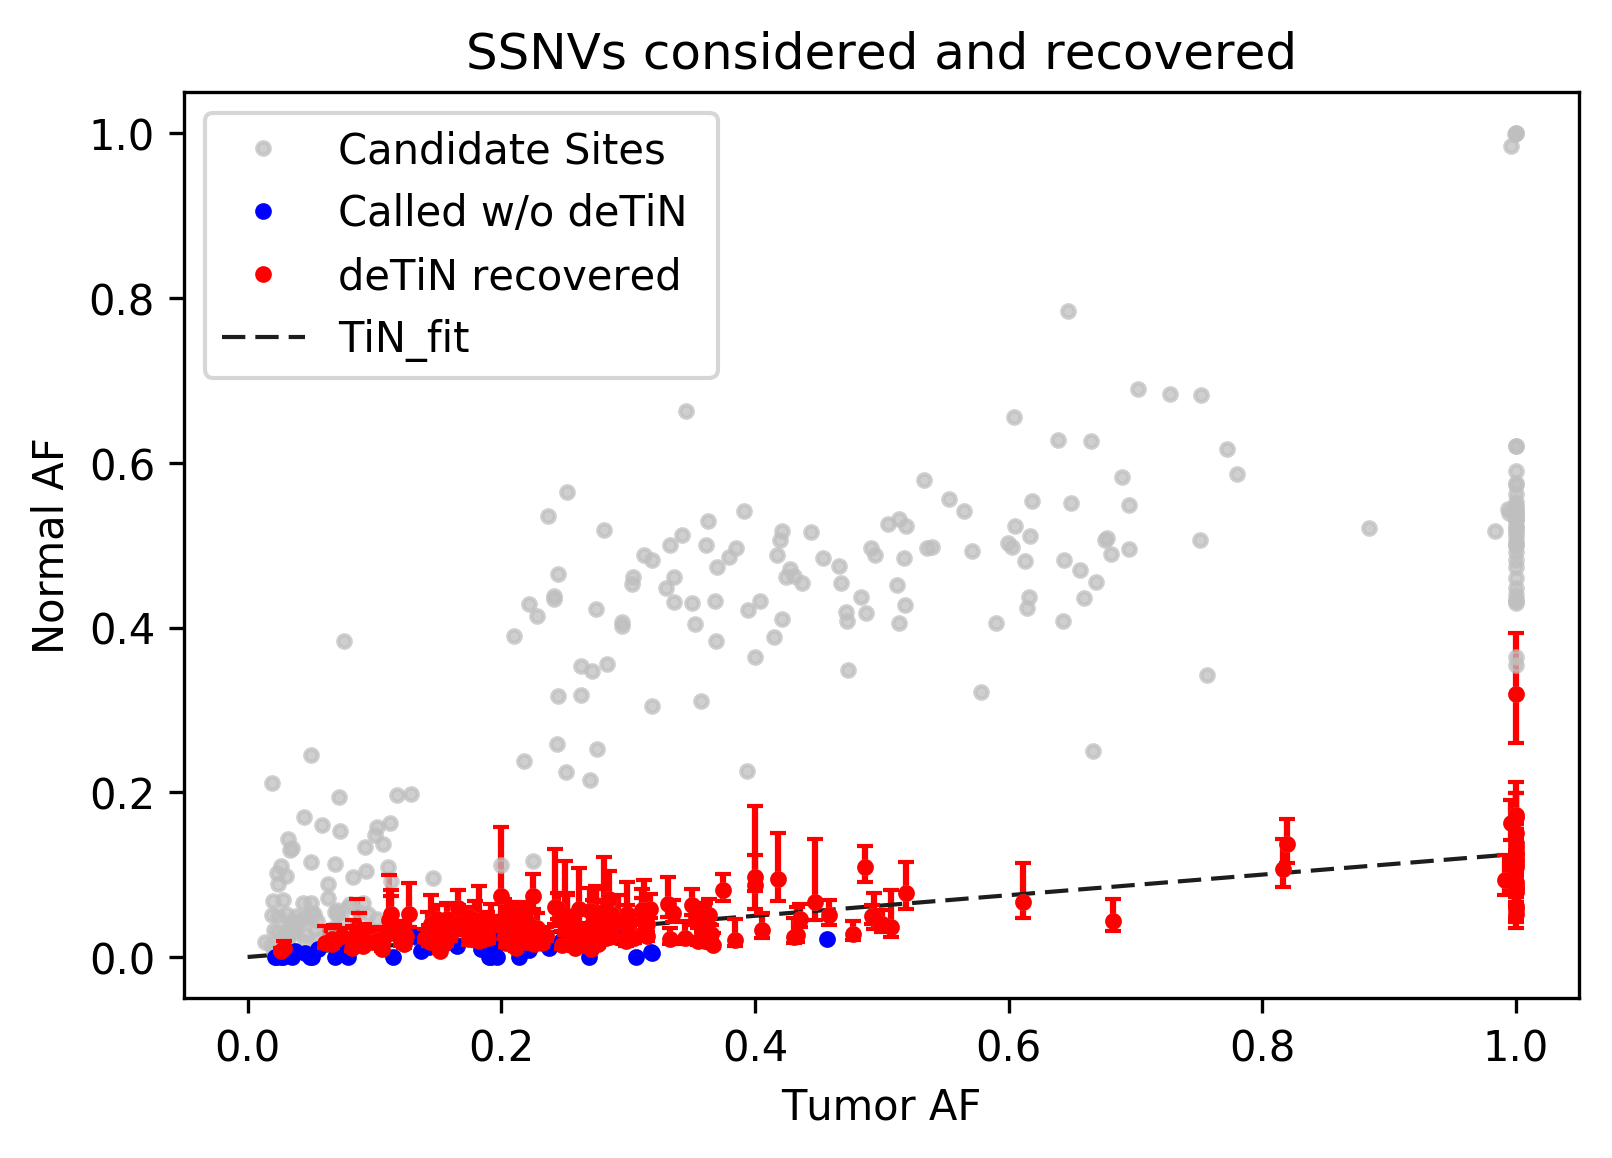

In [33]:
# plot recovered SSNVs based on TiN
du.plot_SSNVs(do)

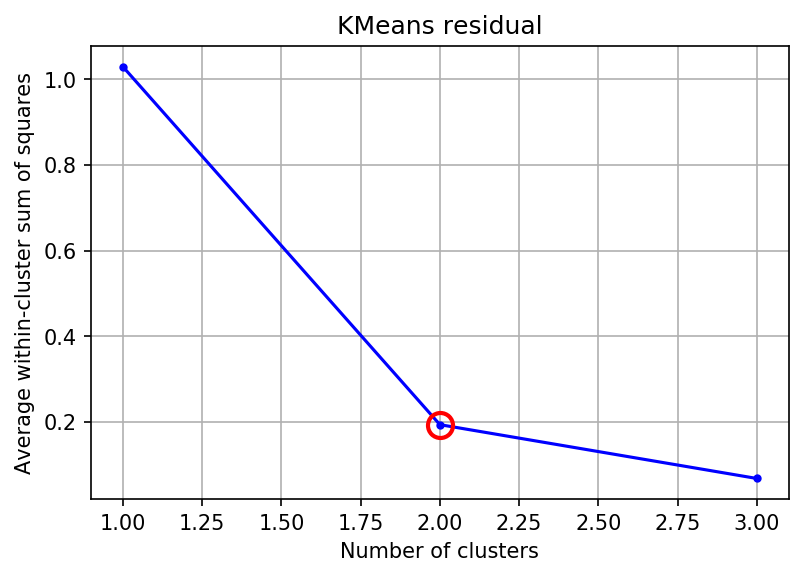

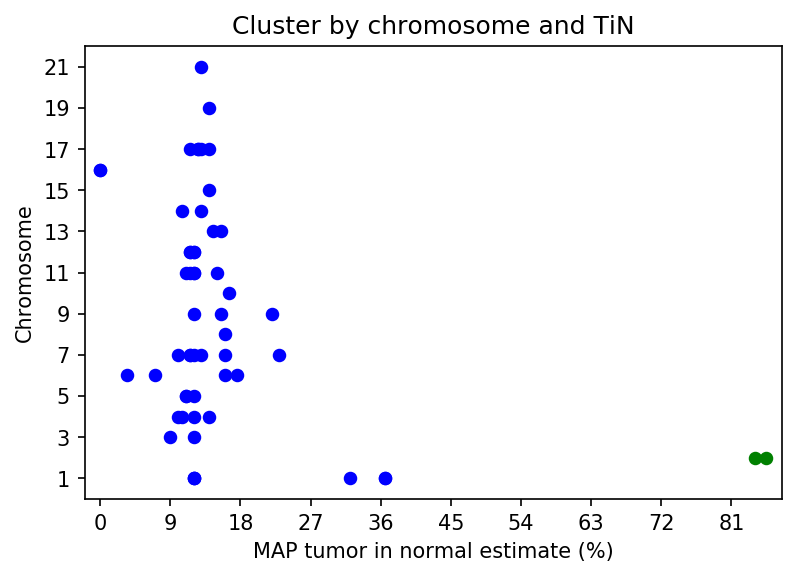

In [34]:
# plot K-means clustering results and RSS information
du.plot_kmeans_info(ascna_based_model,do.input.output_path,do.input.output_name)

In [ ]:
do.SSNVs.to_csv(path_or_buf=do.input.output_path + '/' + do.input.output_name + '_deTiN_SSNVs.txt', sep='\t',index=None)
file = open(do.input.output_path + '/' + do.input.output_name + 'TiN_estimate_CI.txt', 'w')
file.write('%s - %s' % (str(do.CI_tin_low),str(do.CI_tin_high)))
file.close() 
file = open(do.input.output_path +'/' + do.input.output_name + 'TiN_estimate.txt', 'w')
file.write('%d' % (do.TiN))
file.close()